### Installs, Imports, and a Print Callback

In [ ]:
%%capture output
# execute in Colab once per session to install packages
!pip install torchinfo
!pip install pytorch-lightning
!pip install torchmetrics

# uncomment to see output
# print(output)

In [ ]:
# imports and settings
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import os

from torchvision.datasets import FashionMNIST
from torchvision.transforms import transforms

from torchinfo import summary

import pytorch_lightning as pl
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

from torchmetrics.classification import Accuracy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from utils import PrintMetricsCallback, denormalize, sample_dataset, process_experiment_logs

# FashionMNIST - Adding Skip and Residual Connections to a CNN

* Part 0 - preliminaries like loading the datasets and transforms for augmentation.
* Part 1 - build a CNN with multiple layers, ReLU, and MaxPool2D
* Part 2 - add BN
* Part 3 - change ReLU to LeakyReLU(0.1)
* Part 4 - add more CNN blocks without doubling channels
* Part 5 - add skip connections
* Part 6 - change skip connections to ReLU connections

## Part 0 - Preliminaries

In [ ]:
use_augmentation = False
original_mean = [0] # set for each channel
original_std = [1] # for each channel
batch_size = 128
use_subsets = False
num_each_class = 500
threads = 4
workers = 2
seed = 42 # random seed for downsampling

# number of CPU cores to use for individual torch ops
torch.set_num_threads(threads)

# training and validation transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(), # Converts to Tensor and scales pixels between 0 and 1
        transforms.Normalize(mean = original_mean, std = original_std)
    ])

if not use_augmentation:
    train_transform = valid_transform
else:
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        valid_transform,
    ])

# load the datasets and apply transforms
train_set = FashionMNIST(root='./data', train = True, download = True, transform = train_transform )
valid_set = FashionMNIST(root='./data', train = False, download = True, transform = valid_transform )
print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(valid_set)}")

# downsample the datasets if desired
if use_subsets:
    train_set = sample_dataset(train_set, num_samples=num_each_class, random_state=seed)
    valid_set = sample_dataset(valid_set, num_samples=num_each_class, random_state=seed)
    print(f"Sampled Training set size: {len(train_set)}")
    print(f"Sampled Validation set size: {len(valid_set)}")

# build the dataloaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

Training set size: 60000
Validation set size: 10000


Since we'll use the same `LightningModule` for all of our experiments we define it once here.  For each experiment we'll instantiate it with the latest version of our CNN `nn.Module`.

In [ ]:
class MNISTLightningModel(pl.LightningModule):
    def __init__(self, net, num_classes):

        super().__init__()
        self.net = net
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.valid_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.loss_func = nn.CrossEntropyLoss()

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.net(inputs)
        loss = self.loss_func(outputs, targets)
        self.train_acc(outputs, targets)
        self.log_dict( {"train_loss":loss,"train_acc":self.train_acc},
                      on_epoch = True, on_step = False, prog_bar = False)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.net(inputs)
        valid_loss = self.loss_func(outputs, targets)
        self.valid_acc(outputs, targets)
        self.log_dict( {"valid_loss":valid_loss,"valid_acc":self.valid_acc},
                      prog_bar = False)
        return valid_loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        inputs, targets = batch
        outputs = self.net(inputs)
        _, preds = torch.max(outputs, dim=1)
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3)
        return optimizer

For each new network we'll train the model for 10 epochs while printing metrics.  The metrics will be logged to a csv file is processed into a dataframe for viewing and plotting.  Since these steps will be the same for each new network we'll explore.  We'll include the process in a function so we can reuse it for each experiment.  You'll need to pass in your root save path, a short name for your experiment, and an instance of your LightningModule that includes your network and information about training.

In [ ]:
def run_experiment(light_model, root_save_dir, exper_name, max_epochs=10, verbose = 1):
    model_dir = root_save_dir + '/' + exper_name + '/Models'
    csv_logs_dir = root_save_dir + '/' + exper_name + '/CSVLogs'

    # define our callbacks
    print_cb = PrintMetricsCallback(print_epoch=1)
    model_save_cb = ModelCheckpoint(
        dirpath = model_dir,
        filename = exper_name+'-{epoch:02d}-{valid_acc:.2f}',
        monitor='valid_acc',
        mode='max')

    if verbose > 0:
        all_cbs = [print_cb, model_save_cb]
    else:
        all_cbs = [model_save_cb]

    # setup the trainer
    logger = CSVLogger(csv_logs_dir,name="model") # don't change name = "model"

    trainer = pl.Trainer(max_epochs=max_epochs,
                         enable_progress_bar=False,
                         callbacks=all_cbs,
                         num_sanity_val_steps=0,
                         val_check_interval=1.0,
                         logger=logger,
                          )

    # train the model!
    trainer.fit(light_model, train_loader, valid_loader)

    # process the logs
    df = process_experiment_logs(csv_logs_dir, exper_name)

    return df

def plot_valid_acc(df):
    sns.lineplot(data=df, x='epoch',y='valid_acc',hue='exp_name')
    plt.title('Validation Accuracy vs. Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.show()

## Part 1

Build a CNN with multiple layers, ReLU, and MaxPool2D.  

Since we'll be running various experiments with different networks, we'll put everything in one cell for each experiment to simplify the process.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/FashionMNIST/CNN/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | MNISTNet1          | 50.2 K
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTNet1                                [600, 1, 28, 28]          [600, 10]                 --
├─Sequential: 1-1                        [600, 1, 28, 28]          [600, 10]                 --
│    └─ConvBlock: 2-1                    [600, 1, 28, 28]          [600, 32, 14, 14]         --
│    │    └─Sequential: 3-1              [600, 1, 28, 28]          [600, 32, 14, 14]         320
│    └─ConvBlock: 2-2                    [600, 32, 14, 14]         [600, 64, 7, 7]           --
│    │    └─Sequential: 3-2              [600, 32, 14, 14]         [600, 64, 7, 7]           18,496
│    └─Flatten: 2-3                      [600, 64, 7, 7]           [600, 3136]               --
│    └─ClassifierHead: 2-4               [600, 3136]               [600, 10]                 --
│    │    └─Linear: 3-3                  [600, 3136]               [600, 10]                 31,370
Total params: 50,186
Train

/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1 Metrics: valid_loss: 0.3415, valid_acc: 0.8782, train_loss: 0.4541, train_acc: 0.8393
Epoch 2 Metrics: valid_loss: 0.2989, valid_acc: 0.8939, train_loss: 0.3040, train_acc: 0.8917
Epoch 3 Metrics: valid_loss: 0.2728, valid_acc: 0.9026, train_loss: 0.2632, train_acc: 0.9060
Epoch 4 Metrics: valid_loss: 0.2560, valid_acc: 0.9103, train_loss: 0.2386, train_acc: 0.9147
Epoch 5 Metrics: valid_loss: 0.2513, valid_acc: 0.9101, train_loss: 0.2204, train_acc: 0.9213
Epoch 6 Metrics: valid_loss: 0.2559, valid_acc: 0.9084, train_loss: 0.2078, train_acc: 0.9254
Epoch 7 Metrics: valid_loss: 0.2533, valid_acc: 0.9092, train_loss: 0.1955, train_acc: 0.9292
Epoch 8 Metrics: valid_loss: 0.2400, valid_acc: 0.9142, train_loss: 0.1853, train_acc: 0.9337
Epoch 9 Metrics: valid_loss: 0.2629, valid_acc: 0.9061, train_loss: 0.1764, train_acc: 0.9366


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.2418, valid_acc: 0.9157, train_loss: 0.1713, train_acc: 0.9381
End.  Trained for 10 epochs.


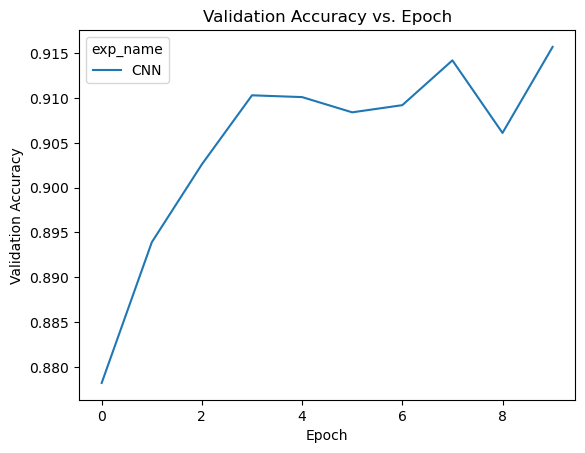

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size = 3):
        super().__init__()
        pad = (kernel_size-1)//2
        stride = 1
        self.block = nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size, stride, pad),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    def forward(self,x):
        return(self.block(x))

class ClassifierHead(nn.Module):
    def __init__(self, num_in, num_out):
        super().__init__()
        self.head = nn.Linear(num_in, num_out)

    def forward(self, x):
        return(self.head(x))

class MNISTNet1(nn.Module):
    '''
    Two convolution layers
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock(1,32),
            ConvBlock(32,64),
            nn.Flatten(),
            ClassifierHead(64*7*7, 10),
        )

    def forward(self, x):
        return(self.layers(x))

net = MNISTNet1()

# use summary() to troubleshoot, but you can comment this out if you don't want to see the output
summary_str = summary(net, input_size = (600,1,28,28), col_names = ["input_size","output_size","num_params"])
print(summary_str)

# give your model a name for the save file, log file, and plot legend, then run the experiment
exper_name = "CNN"
root_save_dir = './FashionMNIST'
net = MNISTNet1()
light_model = MNISTLightningModel(net, num_classes = 10)

df1 = run_experiment(light_model, root_save_dir, exper_name, max_epochs=10, verbose = 1)
plot_valid_acc(df1)

## Part 2

Add batch normalization (BN). It can be included in many places, but a common place to put it is just after each convolutional layer (or group of layers) and before activation and pooling.  Do not include it after the output layer.  We'll add a hidden layer in our classifier and include BN there.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/FashionMNIST/CNN+BN/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | MNISTNet2          | 422 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K     Total params
1.688     Total estimated model params size (MB)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTNet2                                [600, 1, 28, 28]          [600, 10]                 --
├─Sequential: 1-1                        [600, 1, 28, 28]          [600, 10]                 --
│    └─ConvBlock: 2-1                    [600, 1, 28, 28]          [600, 32, 14, 14]         --
│    │    └─Sequential: 3-1              [600, 1, 28, 28]          [600, 32, 14, 14]         --
│    │    │    └─Conv2d: 4-1             [600, 1, 28, 28]          [600, 32, 28, 28]         320
│    │    │    └─BatchNorm2d: 4-2        [600, 32, 28, 28]         [600, 32, 28, 28]         64
│    │    │    └─ReLU: 4-3               [600, 32, 28, 28]         [600, 32, 28, 28]         --
│    │    │    └─MaxPool2d: 4-4          [600, 32, 28, 28]         [600, 32, 14, 14]         --
│    └─ConvBlock: 2-2                    [600, 32, 14, 14]         [600, 64, 7, 7]           --
│    │    └─Sequential: 3-2       

/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1 Metrics: valid_loss: 0.2811, valid_acc: 0.8950, train_loss: 0.3573, train_acc: 0.8756
Epoch 2 Metrics: valid_loss: 0.2373, valid_acc: 0.9132, train_loss: 0.2432, train_acc: 0.9118
Epoch 3 Metrics: valid_loss: 0.2357, valid_acc: 0.9163, train_loss: 0.2083, train_acc: 0.9239
Epoch 4 Metrics: valid_loss: 0.2273, valid_acc: 0.9149, train_loss: 0.1844, train_acc: 0.9326
Epoch 5 Metrics: valid_loss: 0.2285, valid_acc: 0.9187, train_loss: 0.1617, train_acc: 0.9409
Epoch 6 Metrics: valid_loss: 0.2192, valid_acc: 0.9244, train_loss: 0.1495, train_acc: 0.9459
Epoch 7 Metrics: valid_loss: 0.2213, valid_acc: 0.9255, train_loss: 0.1351, train_acc: 0.9505
Epoch 8 Metrics: valid_loss: 0.2219, valid_acc: 0.9233, train_loss: 0.1208, train_acc: 0.9560
Epoch 9 Metrics: valid_loss: 0.2226, valid_acc: 0.9258, train_loss: 0.1101, train_acc: 0.9600


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.2387, valid_acc: 0.9241, train_loss: 0.1000, train_acc: 0.9642
End.  Trained for 10 epochs.


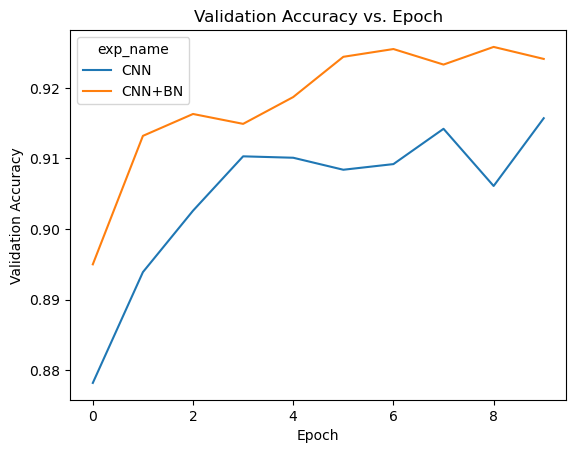

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size = 3):
        super().__init__()
        pad = (kernel_size-1)//2
        stride = 1
        self.block = nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size, stride, pad),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    def forward(self,x):
        return(self.block(x))

class ClassifierHead(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(num_in, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_out)
        )

    def forward(self, x):
        return(self.head(x))

class MNISTNet2(nn.Module):
    '''
    Two convolution layers
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock(1,32),
            ConvBlock(32,64),
            nn.Flatten(),
            ClassifierHead(64*7*7, 128, 10),
        )

    def forward(self, x):
        return(self.layers(x))

net = MNISTNet2()

summary_str = summary(net, input_size = (600,1,28,28), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

exper_name = "CNN+BN"
root_save_dir = './FashionMNIST'
light_model = MNISTLightningModel(net, num_classes = 10)

df2 = run_experiment(light_model, root_save_dir, exper_name, max_epochs=10, verbose = 1)
plot_valid_acc( pd.concat([df1,df2]) )

## Part 3

Change ReLU to LeakyReLU with leak rate 0.1.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/FashionMNIST/CNN+BN+Leaky/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | MNISTNet3          | 422 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K     Total params
1.688     Total estimated model params siz

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTNet3                                [600, 1, 28, 28]          [600, 10]                 --
├─Sequential: 1-1                        [600, 1, 28, 28]          [600, 10]                 --
│    └─ConvBlock: 2-1                    [600, 1, 28, 28]          [600, 32, 14, 14]         --
│    │    └─Sequential: 3-1              [600, 1, 28, 28]          [600, 32, 14, 14]         --
│    │    │    └─Conv2d: 4-1             [600, 1, 28, 28]          [600, 32, 28, 28]         320
│    │    │    └─BatchNorm2d: 4-2        [600, 32, 28, 28]         [600, 32, 28, 28]         64
│    │    │    └─LeakyReLU: 4-3          [600, 32, 28, 28]         [600, 32, 28, 28]         --
│    │    │    └─MaxPool2d: 4-4          [600, 32, 28, 28]         [600, 32, 14, 14]         --
│    └─ConvBlock: 2-2                    [600, 32, 14, 14]         [600, 64, 7, 7]           --
│    │    └─Sequential: 3-2       

/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1 Metrics: valid_loss: 0.2779, valid_acc: 0.9002, train_loss: 0.3570, train_acc: 0.8756
Epoch 2 Metrics: valid_loss: 0.2420, valid_acc: 0.9102, train_loss: 0.2448, train_acc: 0.9107
Epoch 3 Metrics: valid_loss: 0.2404, valid_acc: 0.9128, train_loss: 0.2127, train_acc: 0.9220
Epoch 4 Metrics: valid_loss: 0.2318, valid_acc: 0.9154, train_loss: 0.1917, train_acc: 0.9288
Epoch 5 Metrics: valid_loss: 0.2288, valid_acc: 0.9133, train_loss: 0.1716, train_acc: 0.9366
Epoch 6 Metrics: valid_loss: 0.2214, valid_acc: 0.9194, train_loss: 0.1575, train_acc: 0.9423
Epoch 7 Metrics: valid_loss: 0.2286, valid_acc: 0.9196, train_loss: 0.1425, train_acc: 0.9476
Epoch 8 Metrics: valid_loss: 0.2267, valid_acc: 0.9224, train_loss: 0.1335, train_acc: 0.9505
Epoch 9 Metrics: valid_loss: 0.2193, valid_acc: 0.9277, train_loss: 0.1210, train_acc: 0.9555


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.2398, valid_acc: 0.9217, train_loss: 0.1119, train_acc: 0.9593
End.  Trained for 10 epochs.


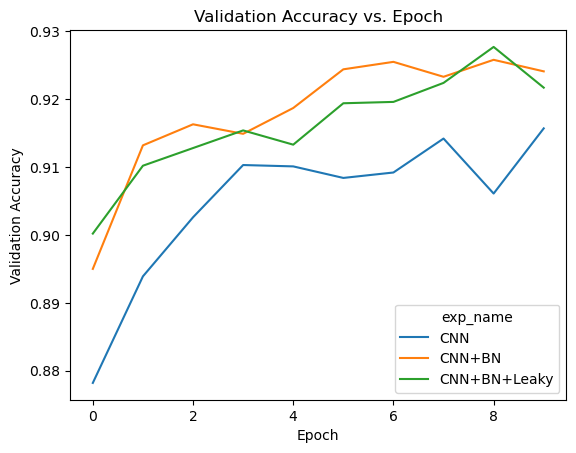

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size = 3, leak_rate = 0.1):
        super().__init__()
        pad = (kernel_size-1)//2
        stride = 1
        self.block = nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size, stride, pad),
            nn.BatchNorm2d(out_chan),
            nn.LeakyReLU(leak_rate),
            nn.MaxPool2d(2)
        )
    def forward(self,x):
        return(self.block(x))

class ClassifierHead(nn.Module):
    def __init__(self, num_in, num_hidden, num_out, leak_rate = 0.1):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(num_in, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.LeakyReLU(0.1),
            nn.Linear(num_hidden, num_out)
        )

    def forward(self, x):
        return(self.head(x))

class MNISTNet3(nn.Module):
    '''
    Two convolution layers
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock(1,32),
            ConvBlock(32,64),
            nn.Flatten(),
            ClassifierHead(64*7*7, 128, 10),
        )

    def forward(self, x):
        return(self.layers(x))

net = MNISTNet3()

summary_str = summary(net, input_size = (600,1,28,28), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

exper_name = "CNN+BN+Leaky"
root_save_dir = './FashionMNIST'
light_model = MNISTLightningModel(net, num_classes = 10)

df3 = run_experiment(light_model, root_save_dir, exper_name, max_epochs=10, verbose = 1)
plot_valid_acc( pd.concat([df1,df2,df3]) )

## Part 4

Add an extra convolutional layer + activation in each convolutional block to deepen the network and allow it to learn more.  

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/FashionMNIST/More_CNN+BN+Leaky/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | MNISTNet3          | 422 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
422 K     Trainable params
0         Non-trainable params
422 K     Total params
1.688     Total estimated model param

Beginning training for at most 10 epochs


/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1 Metrics: valid_loss: 0.2253, valid_acc: 0.9256, train_loss: 0.1042, train_acc: 0.9615
Epoch 2 Metrics: valid_loss: 0.2392, valid_acc: 0.9224, train_loss: 0.0971, train_acc: 0.9646
Epoch 3 Metrics: valid_loss: 0.2346, valid_acc: 0.9253, train_loss: 0.0902, train_acc: 0.9668
Epoch 4 Metrics: valid_loss: 0.2476, valid_acc: 0.9245, train_loss: 0.0803, train_acc: 0.9713
Epoch 5 Metrics: valid_loss: 0.2502, valid_acc: 0.9224, train_loss: 0.0781, train_acc: 0.9717
Epoch 6 Metrics: valid_loss: 0.2574, valid_acc: 0.9248, train_loss: 0.0737, train_acc: 0.9732
Epoch 7 Metrics: valid_loss: 0.2800, valid_acc: 0.9179, train_loss: 0.0648, train_acc: 0.9761
Epoch 8 Metrics: valid_loss: 0.2645, valid_acc: 0.9219, train_loss: 0.0623, train_acc: 0.9765
Epoch 9 Metrics: valid_loss: 0.2687, valid_acc: 0.9241, train_loss: 0.0586, train_acc: 0.9784


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.2777, valid_acc: 0.9228, train_loss: 0.0550, train_acc: 0.9801
End.  Trained for 10 epochs.


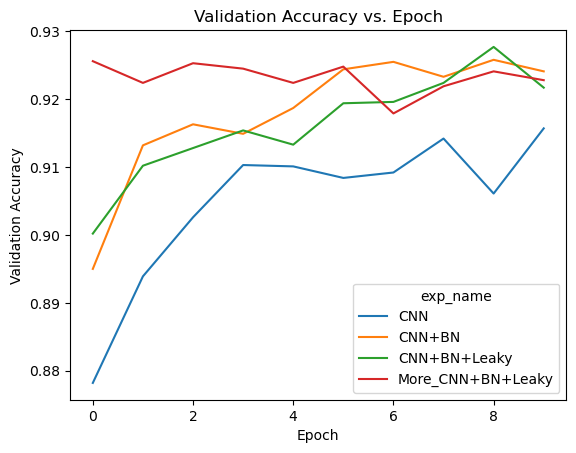

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size = 3, leak_rate = 0.1):
        super().__init__()
        pad = (kernel_size-1)//2
        stride = 1
        self.block = nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size, stride, pad),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(out_chan, out_chan, kernel_size, stride, pad),
            nn.BatchNorm2d(out_chan),
            nn.LeakyReLU(leak_rate),
            nn.MaxPool2d(2)
        )
    def forward(self,x):
        return(self.block(x))

class ClassifierHead(nn.Module):
    def __init__(self, num_in, num_hidden, num_out, leak_rate = 0.1):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(num_in, num_hidden),
            nn.BatchNorm1d(num_hidden),
            nn.LeakyReLU(0.1),
            nn.Linear(num_hidden, num_out)
        )

    def forward(self, x):
        return(self.head(x))

class MNISTNet4(nn.Module):
    '''
    Two convolution layers
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock(1,32),
            ConvBlock(32,64),
            ConvBlock(64,128),
            nn.Flatten(),
            ClassifierHead(128*3*3, 128, 10),
        )

    def forward(self, x):
        return(self.layers(x))


net = MNISTNet4()

summary_str = summary(net, input_size = (600,1,28,28), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

exper_name = "More_CNN+BN+Leaky"
root_save_dir = './FashionMNIST'
light_model = MNISTLightningModel(net, num_classes = 10)

df4 = run_experiment(light_model, root_save_dir, exper_name, max_epochs=10, verbose = 1)
plot_valid_acc( pd.concat([df1,df2,df3, df4]) )

## Part 5

Add skip connections to each of convolutional blocks in the previous CNN.  We'll have to change the structure of our layer a little since the skip connections have to be before the pooling (pooling changes the dimensions of the feature maps).  We'll also add extra convolutional layer to map the three channels to more channels so that first convolutional block can be more effective.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/FashionMNIST/CNN+BN+Leaky+Skip/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 636 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
636 K     Trainable params
0         Non-trainable params
636 K     Total params
2.545     Total estimated model param

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [600, 1, 28, 28]          [600, 10]                 --
├─Conv2d: 1-1                            [600, 1, 28, 28]          [600, 32, 28, 28]         320
├─SkipConv2d: 1-2                        [600, 32, 28, 28]         [600, 64, 28, 28]         --
│    └─ModuleList: 2-7                   --                        --                        (recursive)
│    │    └─Conv2d: 3-1                  [600, 32, 28, 28]         [600, 32, 28, 28]         9,248
│    └─ModuleList: 2-8                   --                        --                        (recursive)
│    │    └─BatchNorm2d: 3-2             [600, 32, 28, 28]         [600, 32, 28, 28]         64
│    └─LeakyReLU: 2-3                    [600, 32, 28, 28]         [600, 32, 28, 28]         --
│    └─ModuleList: 2-7                   --                        --                        (recursive)
│   

/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1 Metrics: valid_loss: 0.3221, valid_acc: 0.8812, train_loss: 0.4015, train_acc: 0.8566
Epoch 2 Metrics: valid_loss: 0.3100, valid_acc: 0.8918, train_loss: 0.2641, train_acc: 0.9047
Epoch 3 Metrics: valid_loss: 0.2646, valid_acc: 0.9051, train_loss: 0.2245, train_acc: 0.9196
Epoch 4 Metrics: valid_loss: 0.2498, valid_acc: 0.9148, train_loss: 0.2021, train_acc: 0.9262
Epoch 5 Metrics: valid_loss: 0.2190, valid_acc: 0.9221, train_loss: 0.1848, train_acc: 0.9326
Epoch 6 Metrics: valid_loss: 0.2266, valid_acc: 0.9188, train_loss: 0.1711, train_acc: 0.9376
Epoch 7 Metrics: valid_loss: 0.2273, valid_acc: 0.9198, train_loss: 0.1539, train_acc: 0.9439
Epoch 8 Metrics: valid_loss: 0.1980, valid_acc: 0.9323, train_loss: 0.1419, train_acc: 0.9491
Epoch 9 Metrics: valid_loss: 0.1955, valid_acc: 0.9335, train_loss: 0.1279, train_acc: 0.9536


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.2075, valid_acc: 0.9327, train_loss: 0.1175, train_acc: 0.9578
End.  Trained for 10 epochs.


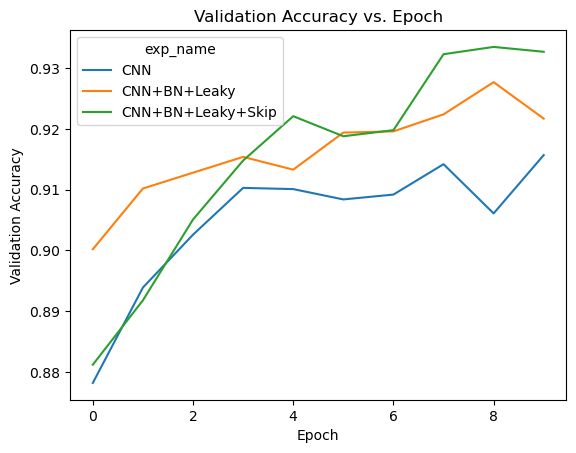

In [ ]:
class SkipConv2d(nn.Module):
    def __init__(self, n_layers, in_channels, out_channels, kernel_size=3, leak_rate=0.1):
        super().__init__()

        #The last convolution will have a different number of inputs and output channels, so we still need that index
        l = n_layers-1
        #this is just simple helper values
        f = (kernel_size, kernel_size)
        pad = (kernel_size-1)//2

        #Defining the layers used, altering the construction of the last layer using the same `if i == l` list comprehension. We are going to combine convolutions via their channels, so the in and out channels change for the last layer.
        self.layers = nn.ModuleList([nn.Conv2d(in_channels*l, out_channels, kernel_size=f, padding=pad) if i == l else nn.Conv2d(in_channels, in_channels, kernel_size=f, padding=pad) for i in range(n_layers)])
        self.bns = nn.ModuleList([nn.BatchNorm2d(out_channels) if i == l else nn.BatchNorm2d(in_channels) for i in range(n_layers)])

        self.activation = nn.LeakyReLU(leak_rate)

    def forward(self, x):
        #This code is identical to the SkipFC class, but its worth highliting the most important line that could change.
        activations = []

        for layer, bn in zip(self.layers[:-1], self.bns[:-1]):
            x = self.activation(bn(layer(x)))
            activations.append( x )
        #Which is the concatination of all the activations here. Our tensors are organized as (B, C, W, H), which is the default in PyTorch. But you can change that, and sometimes people use (B, W, H, C). In that situation the C channel is at index 3 instead of 1. So you would change `cat=3` in that scenario. This is also how you would adapt this code to work with RNNs
        x = torch.cat(activations, dim=1)

        return self.activation(self.bns[-1](self.layers[-1](x)))

#Whats the width and height of our images?
W, H = 28, 28 #
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images
#Hidden layer size
n = 256
#How many channels are in the input?
C = 1
#how many filters per convolutional layer
n_filters = 32
#How many classes are there?
classes = 10#

net = cnn_skip_model = nn.Sequential(
    nn.Conv2d(C, n_filters, (3,3), padding=1),
    SkipConv2d(3, n_filters, 2*n_filters),
    nn.MaxPool2d((2,2)),
    nn.LeakyReLU(),
    SkipConv2d(3, 2*n_filters, 4*n_filters),
    nn.MaxPool2d((2,2)),
    SkipConv2d(2, 4*n_filters, 4*n_filters),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

summary_str = summary(net, input_size = (600,1,28,28), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

exper_name = "CNN+BN+Leaky+Skip"
root_save_dir = './FashionMNIST'
light_model = MNISTLightningModel(net, num_classes = 10)

df6 = run_experiment(light_model, root_save_dir, exper_name, max_epochs=10, verbose = 1)
plot_valid_acc( pd.concat([df1,df3,df6]) )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/FashionMNIST/CNN/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 395 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
395 K     Trainable params
0         Non-trainable params
395 K     Total params
1.581     Total estimated model params size (MB)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [600, 1, 28, 28]          [600, 10]                 --
├─Conv2d: 1-1                            [600, 1, 28, 28]          [600, 32, 28, 28]         320
├─Tanh: 1-2                              [600, 32, 28, 28]         [600, 32, 28, 28]         --
├─Conv2d: 1-3                            [600, 32, 28, 28]         [600, 32, 28, 28]         9,248
├─Tanh: 1-4                              [600, 32, 28, 28]         [600, 32, 28, 28]         --
├─Conv2d: 1-5                            [600, 32, 28, 28]         [600, 32, 28, 28]         9,248
├─Tanh: 1-6                              [600, 32, 28, 28]         [600, 32, 28, 28]         --
├─MaxPool2d: 1-7                         [600, 32, 28, 28]         [600, 32, 14, 14]         --
├─Conv2d: 1-8                            [600, 32, 14, 14]         [600, 64, 14, 14]         18,496
├─Tanh: 1-9             

/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1 Metrics: valid_loss: 0.3441, valid_acc: 0.8769, train_loss: 0.4934, train_acc: 0.8235
Epoch 2 Metrics: valid_loss: 0.3268, valid_acc: 0.8806, train_loss: 0.3175, train_acc: 0.8873
Epoch 3 Metrics: valid_loss: 0.3081, valid_acc: 0.8928, train_loss: 0.2807, train_acc: 0.9022
Epoch 4 Metrics: valid_loss: 0.2788, valid_acc: 0.9013, train_loss: 0.2644, train_acc: 0.9058
Epoch 5 Metrics: valid_loss: 0.2928, valid_acc: 0.8993, train_loss: 0.2469, train_acc: 0.9144
Epoch 6 Metrics: valid_loss: 0.3403, valid_acc: 0.8879, train_loss: 0.2252, train_acc: 0.9211
Epoch 7 Metrics: valid_loss: 0.3601, valid_acc: 0.8881, train_loss: 0.2223, train_acc: 0.9228
Epoch 8 Metrics: valid_loss: 0.3144, valid_acc: 0.9019, train_loss: 0.2134, train_acc: 0.9274
Epoch 9 Metrics: valid_loss: 0.3452, valid_acc: 0.9026, train_loss: 0.2018, train_acc: 0.9310


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.3623, valid_acc: 0.9026, train_loss: 0.1988, train_acc: 0.9340
End.  Trained for 10 epochs.


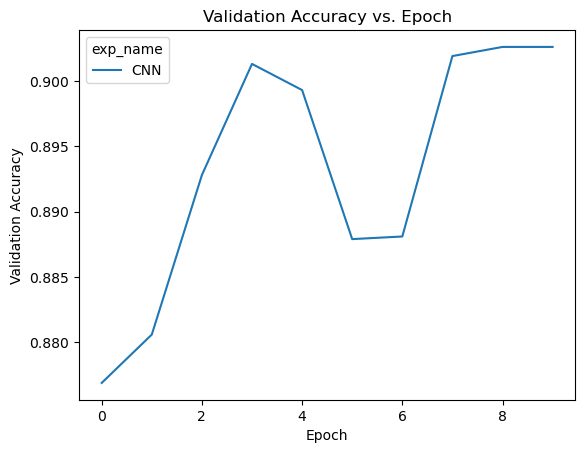

In [ ]:
# Vanilla CNN

#Whats the width and height of our images?
W, H = 28, 28 #
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images
#Hidden layer size
n = 256
#How many channels are in the input?
C = 1
#how many filters per convolutional layer
n_filters = 32
#How many classes are there?
classes = 10#

cnn_model = nn.Sequential(
    nn.Conv2d(C, n_filters, 3, padding=1),             nn.Tanh(),
    nn.Conv2d(n_filters, n_filters, 3, padding=1),     nn.Tanh(),
    nn.Conv2d(n_filters, n_filters, 3, padding=1),     nn.Tanh(),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(  n_filters, 2*n_filters, 3, padding=1), nn.Tanh(),
    nn.Conv2d(2*n_filters, 2*n_filters, 3, padding=1), nn.Tanh(),
    nn.Conv2d(2*n_filters, 2*n_filters, 3, padding=1), nn.Tanh(),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(2*n_filters, 4*n_filters, 3, padding=1), nn.Tanh(),
    nn.Conv2d(4*n_filters, 4*n_filters, 3, padding=1), nn.Tanh(),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)

summary_str = summary(cnn_model, input_size = (600,1,28,28), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

exper_name = "CNN"
root_save_dir = './FashionMNIST'
light_model = MNISTLightningModel(cnn_model, num_classes = 10)

df10 = run_experiment(light_model, root_save_dir, exper_name, max_epochs=10, verbose = 1)
plot_valid_acc( pd.concat([df10]) )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/FashionMNIST/CNN_ReLU/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 395 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
395 K     Trainable params
0         Non-trainable params
395 K     Total params
1.581     Total estimated model params size (M

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [600, 1, 28, 28]          [600, 10]                 --
├─Sequential: 1-1                        [600, 1, 28, 28]          [600, 32, 28, 28]         --
│    └─Conv2d: 2-1                       [600, 1, 28, 28]          [600, 32, 28, 28]         320
│    └─LeakyReLU: 2-2                    [600, 32, 28, 28]         [600, 32, 28, 28]         --
├─Sequential: 1-2                        [600, 32, 28, 28]         [600, 32, 28, 28]         --
│    └─Conv2d: 2-3                       [600, 32, 28, 28]         [600, 32, 28, 28]         9,248
│    └─LeakyReLU: 2-4                    [600, 32, 28, 28]         [600, 32, 28, 28]         --
├─Sequential: 1-3                        [600, 32, 28, 28]         [600, 32, 28, 28]         --
│    └─Conv2d: 2-5                       [600, 32, 28, 28]         [600, 32, 28, 28]         9,248
│    └─LeakyReLU: 2-6       

/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1 Metrics: valid_loss: 0.3733, valid_acc: 0.8592, train_loss: 0.5407, train_acc: 0.7988
Epoch 2 Metrics: valid_loss: 0.2860, valid_acc: 0.8955, train_loss: 0.2971, train_acc: 0.8918
Epoch 3 Metrics: valid_loss: 0.2510, valid_acc: 0.9088, train_loss: 0.2435, train_acc: 0.9115
Epoch 4 Metrics: valid_loss: 0.2266, valid_acc: 0.9190, train_loss: 0.2110, train_acc: 0.9229
Epoch 5 Metrics: valid_loss: 0.2208, valid_acc: 0.9206, train_loss: 0.1894, train_acc: 0.9306
Epoch 6 Metrics: valid_loss: 0.2207, valid_acc: 0.9197, train_loss: 0.1706, train_acc: 0.9377
Epoch 7 Metrics: valid_loss: 0.2101, valid_acc: 0.9246, train_loss: 0.1534, train_acc: 0.9442
Epoch 8 Metrics: valid_loss: 0.2080, valid_acc: 0.9280, train_loss: 0.1372, train_acc: 0.9493
Epoch 9 Metrics: valid_loss: 0.2160, valid_acc: 0.9279, train_loss: 0.1237, train_acc: 0.9549


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.2388, valid_acc: 0.9231, train_loss: 0.1068, train_acc: 0.9611
End.  Trained for 10 epochs.


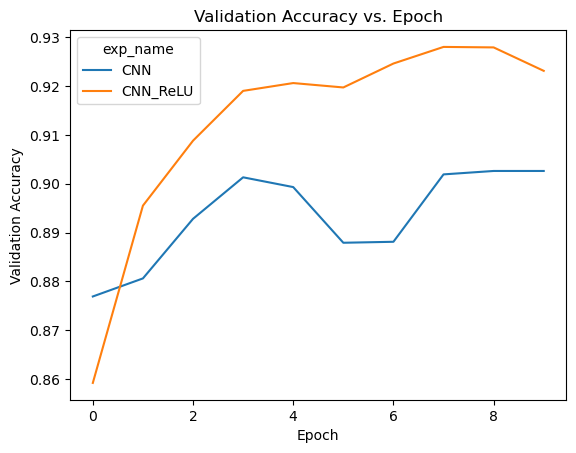

In [ ]:
# CNN + LeakyReLU (changed Tanh to LeakyReLU)

#Whats the width and height of our images?
W, H = 28, 28 #
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images
#Hidden layer size
n = 256
#How many channels are in the input?
C = 1
#how many filters per convolutional layer
n_filters = 32
#How many classes are there?
classes = 10

def cnnLayer(in_filters, out_filters=None, kernel_size=3, leak_rate=0.1):
    """
    in_filters: how many channels are coming into the layer
    out_filters: how many channels this layer should learn / output, or `None` if we want to have the same number of channels as the input.
    kernel_size: how large the kernel should be
    """
    if out_filters is None:
        out_filters = in_filters #This is a common pattern, so lets automate it as a default if not asked
    padding=kernel_size//2 #padding to stay the same size
    return nn.Sequential( # Combine the layer and activation into a single unit
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
        nn.LeakyReLU(leak_rate)
    )

cnn_relu_model = nn.Sequential(
    cnnLayer(C, n_filters), cnnLayer(n_filters), cnnLayer(n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(n_filters, 2*n_filters), cnnLayer(2*n_filters), cnnLayer(2*n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(2*n_filters, 4*n_filters), cnnLayer(4*n_filters),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)


summary_str = summary(cnn_relu_model, input_size = (600,1,28,28), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

exper_name = "CNN_ReLU"
root_save_dir = './FashionMNIST'
light_model = MNISTLightningModel(cnn_relu_model, num_classes = 10)

df11 = run_experiment(light_model, root_save_dir, exper_name, max_epochs=10, verbose = 1)
plot_valid_acc( pd.concat([df10, df11]) )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/FashionMNIST/CNN_ReLU_BN/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 396 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
396 K     Trainable params
0         Non-trainable params
396 K     Total params
1.586     Total estimated model params size

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [600, 1, 28, 28]          [600, 10]                 --
├─Sequential: 1-1                        [600, 1, 28, 28]          [600, 32, 28, 28]         --
│    └─Conv2d: 2-1                       [600, 1, 28, 28]          [600, 32, 28, 28]         320
│    └─BatchNorm2d: 2-2                  [600, 32, 28, 28]         [600, 32, 28, 28]         64
│    └─LeakyReLU: 2-3                    [600, 32, 28, 28]         [600, 32, 28, 28]         --
├─Sequential: 1-2                        [600, 32, 28, 28]         [600, 32, 28, 28]         --
│    └─Conv2d: 2-4                       [600, 32, 28, 28]         [600, 32, 28, 28]         9,248
│    └─BatchNorm2d: 2-5                  [600, 32, 28, 28]         [600, 32, 28, 28]         64
│    └─LeakyReLU: 2-6                    [600, 32, 28, 28]         [600, 32, 28, 28]         --
├─Sequential: 1-3              

/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1 Metrics: valid_loss: 0.2900, valid_acc: 0.9014, train_loss: 0.3503, train_acc: 0.8738
Epoch 2 Metrics: valid_loss: 0.2441, valid_acc: 0.9108, train_loss: 0.2281, train_acc: 0.9179
Epoch 3 Metrics: valid_loss: 0.2154, valid_acc: 0.9221, train_loss: 0.1932, train_acc: 0.9292
Epoch 4 Metrics: valid_loss: 0.2317, valid_acc: 0.9211, train_loss: 0.1642, train_acc: 0.9413
Epoch 5 Metrics: valid_loss: 0.2138, valid_acc: 0.9262, train_loss: 0.1455, train_acc: 0.9476
Epoch 6 Metrics: valid_loss: 0.2012, valid_acc: 0.9321, train_loss: 0.1242, train_acc: 0.9556
Epoch 7 Metrics: valid_loss: 0.2251, valid_acc: 0.9259, train_loss: 0.1054, train_acc: 0.9620
Epoch 8 Metrics: valid_loss: 0.2172, valid_acc: 0.9311, train_loss: 0.0916, train_acc: 0.9662
Epoch 9 Metrics: valid_loss: 0.2371, valid_acc: 0.9234, train_loss: 0.0750, train_acc: 0.9728


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.2280, valid_acc: 0.9325, train_loss: 0.0646, train_acc: 0.9770
End.  Trained for 10 epochs.


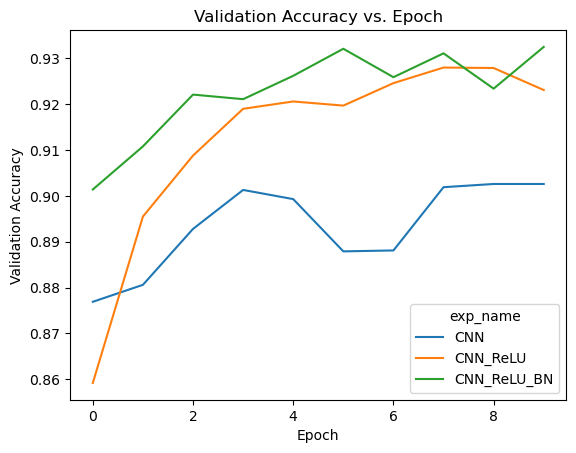

In [ ]:
# CNN + BatchNorm + LeakyReLU

#Whats the width and height of our images?
W, H = 28, 28 #
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images
#Hidden layer size
n = 256
#How many channels are in the input?
C = 1
#how many filters per convolutional layer
n_filters = 32
#How many classes are there?
classes = 10

def cnnLayer(in_filters, out_filters=None, kernel_size=3, leak_rate=0.1):
    """
    in_filters: how many channels are coming into the layer
    out_filters: how many channels this layer should learn / output, or `None` if we want to have the same number of channels as the input.
    kernel_size: how large the kernel should be
    """
    if out_filters is None:
        out_filters = in_filters #This is a common pattern, so lets automate it as a default if not asked
    padding=kernel_size//2 #padding to stay the same size
    return nn.Sequential( # Combine the layer and activation into a single unit
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
        nn.BatchNorm2d(out_filters), #The only change, adding BatchNorm2d after our convolution!
        nn.LeakyReLU(leak_rate)
    )

cnn_bn_model = nn.Sequential(
    cnnLayer(C, n_filters), cnnLayer(n_filters), cnnLayer(n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(n_filters, 2*n_filters), cnnLayer(2*n_filters), cnnLayer(2*n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(2*n_filters, 4*n_filters), cnnLayer(4*n_filters),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)


summary_str = summary(cnn_bn_model, input_size = (600,1,28,28), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

exper_name = "CNN_ReLU_BN"
root_save_dir = './FashionMNIST'
light_model = MNISTLightningModel(cnn_bn_model, num_classes = 10)

df12 = run_experiment(light_model, root_save_dir, exper_name, max_epochs=10, verbose = 1)
plot_valid_acc( pd.concat([df10, df11, df12]) )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /Users/jbaggett/Library/CloudStorage/GoogleDrive-baggett.jeff@gmail.com/My Drive/Colab Notebooks/FashionMNIST/CNN_ReLU_BN_Skip/Models exists and is not empty.

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 636 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
636 K     Trainable params
0         Non-trainable params
636 K     Total params
2.545     Total estimated model params

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [600, 1, 28, 28]          [600, 10]                 --
├─Conv2d: 1-1                            [600, 1, 28, 28]          [600, 32, 28, 28]         320
├─SkipConv2d: 1-2                        [600, 32, 28, 28]         [600, 64, 28, 28]         --
│    └─ModuleList: 2-7                   --                        --                        (recursive)
│    │    └─Conv2d: 3-1                  [600, 32, 28, 28]         [600, 32, 28, 28]         9,248
│    └─ModuleList: 2-8                   --                        --                        (recursive)
│    │    └─BatchNorm2d: 3-2             [600, 32, 28, 28]         [600, 32, 28, 28]         64
│    └─LeakyReLU: 2-3                    [600, 32, 28, 28]         [600, 32, 28, 28]         --
│    └─ModuleList: 2-7                   --                        --                        (recursive)
│   

/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1 Metrics: valid_loss: 0.2747, valid_acc: 0.9035, train_loss: 0.3638, train_acc: 0.8673
Epoch 2 Metrics: valid_loss: 0.2700, valid_acc: 0.9064, train_loss: 0.2432, train_acc: 0.9131
Epoch 3 Metrics: valid_loss: 0.2383, valid_acc: 0.9164, train_loss: 0.1969, train_acc: 0.9280
Epoch 4 Metrics: valid_loss: 0.2183, valid_acc: 0.9256, train_loss: 0.1706, train_acc: 0.9384
Epoch 5 Metrics: valid_loss: 0.2067, valid_acc: 0.9264, train_loss: 0.1487, train_acc: 0.9462
Epoch 6 Metrics: valid_loss: 0.2241, valid_acc: 0.9240, train_loss: 0.1298, train_acc: 0.9534
Epoch 7 Metrics: valid_loss: 0.2094, valid_acc: 0.9296, train_loss: 0.1098, train_acc: 0.9604
Epoch 8 Metrics: valid_loss: 0.2303, valid_acc: 0.9293, train_loss: 0.0958, train_acc: 0.9653
Epoch 9 Metrics: valid_loss: 0.2281, valid_acc: 0.9271, train_loss: 0.0770, train_acc: 0.9724


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.2536, valid_acc: 0.9289, train_loss: 0.0633, train_acc: 0.9769
End.  Trained for 10 epochs.


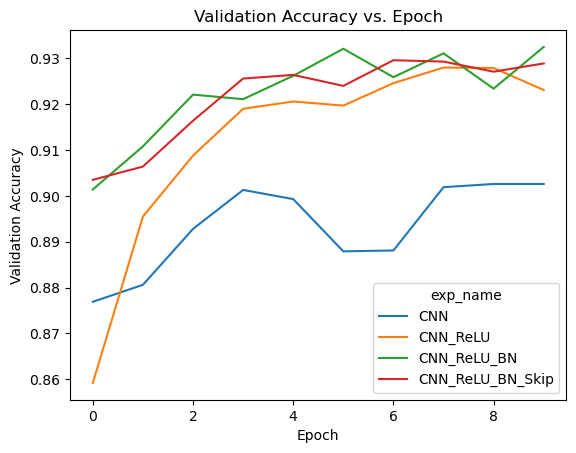

In [ ]:
# CNN + BatchNorm + LeakyReLU + Skip Connections

#Whats the width and height of our images?
W, H = 28, 28 #
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images
#Hidden layer size
n = 256
#How many channels are in the input?
C = 1
#how many filters per convolutional layer
n_filters = 32
#How many classes are there?
classes = 10

class SkipConv2d(nn.Module):
    def __init__(self, n_layers, in_channels, out_channels, kernel_size=3, leak_rate=0.1):
        super().__init__()

        #The last convolution will have a different number of inputs and output channels, so we still need that index
        l = n_layers-1
        #this is just simple helper values
        f = (kernel_size, kernel_size)
        pad = (kernel_size-1)//2

        #Defining the layers used, altering the construction of the last layer using the same `if i == l` list comprehension. We are going to combine convolutions via their channels, so the in and out channels change for the last layer.
        self.layers = nn.ModuleList([nn.Conv2d(in_channels*l, out_channels, kernel_size=f, padding=pad) if i == l else nn.Conv2d(in_channels, in_channels, kernel_size=f, padding=pad) for i in range(n_layers)])
        self.bns = nn.ModuleList([nn.BatchNorm2d(out_channels) if i == l else nn.BatchNorm2d(in_channels) for i in range(n_layers)])

        self.activation = nn.LeakyReLU(leak_rate)

    def forward(self, x):
        #This code is identical to the SkipFC class, but its worth highliting the most important line that could change.
        activations = []

        for layer, bn in zip(self.layers[:-1], self.bns[:-1]):
            x = self.activation(bn(layer(x)))
            activations.append( x )
        #Which is the concatination of all the activations here. Our tensors are organized as (B, C, W, H), which is the default in PyTorch. But you can change that, and sometimes people use (B, W, H, C). In that situation the C channel is at index 3 instead of 1. So you would change `cat=3` in that scenario. This is also how you would adapt this code to work with RNNs
        x = torch.cat(activations, dim=1)

        return self.activation(self.bns[-1](self.layers[-1](x)))

cnn_skip_model = nn.Sequential(
    nn.Conv2d(C, n_filters, (3,3), padding=1),
    SkipConv2d(3, n_filters, 2*n_filters),
    nn.MaxPool2d((2,2)),
    nn.LeakyReLU(),
    SkipConv2d(3, 2*n_filters, 4*n_filters),
    nn.MaxPool2d((2,2)),
    SkipConv2d(2, 4*n_filters, 4*n_filters),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)


summary_str = summary(cnn_skip_model, input_size = (600,1,28,28), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

exper_name = "CNN_ReLU_BN_Skip"
root_save_dir = './FashionMNIST'
light_model = MNISTLightningModel(cnn_skip_model, num_classes = 10)

df13 = run_experiment(light_model, root_save_dir, exper_name, max_epochs=10, verbose = 1)
plot_valid_acc( pd.concat([df10, df11, df12, df13]) )

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
Missing logger folder: ./FashionMNIST/CNN_ReLU_BN_Res/CSVLogs/model

  | Name      | Type               | Params
-------------------------------------------------
0 | net       | Sequential         | 525 K 
1 | train_acc | MulticlassAccuracy | 0     
2 | valid_acc | MulticlassAccuracy | 0     
3 | loss_func | CrossEntropyLoss   | 0     
-------------------------------------------------
525 K     Trainable params
0         Non-trainable params
525 K     Total params
2.102     Total estimated model params size (MB)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [600, 1, 28, 28]          [600, 10]                 --
├─ResidualBottleNeck: 1-1                [600, 1, 28, 28]          [600, 32, 28, 28]         --
│    └─Sequential: 2-1                   [600, 1, 28, 28]          [600, 32, 28, 28]         --
│    │    └─Conv2d: 3-1                  [600, 1, 28, 28]          [600, 32, 28, 28]         64
│    │    └─BatchNorm2d: 3-2             [600, 32, 28, 28]         [600, 32, 28, 28]         64
│    └─Sequential: 2-2                   [600, 1, 28, 28]          [600, 32, 28, 28]         --
│    │    └─BatchNorm2d: 3-3             [600, 1, 28, 28]          [600, 1, 28, 28]          2
│    │    └─LeakyReLU: 3-4               [600, 1, 28, 28]          [600, 1, 28, 28]          --
│    │    └─Conv2d: 3-5                  [600, 1, 28, 28]          [600, 8, 28, 28]          16
│    │    └─BatchNorm2d: 3-6        

/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/jbaggett/miniforge3/envs/introdl/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1 Metrics: valid_loss: 0.2731, valid_acc: 0.8986, train_loss: 0.3809, train_acc: 0.8649
Epoch 2 Metrics: valid_loss: 0.2523, valid_acc: 0.9088, train_loss: 0.2285, train_acc: 0.9166
Epoch 3 Metrics: valid_loss: 0.2377, valid_acc: 0.9143, train_loss: 0.1897, train_acc: 0.9313
Epoch 4 Metrics: valid_loss: 0.2211, valid_acc: 0.9236, train_loss: 0.1639, train_acc: 0.9402
Epoch 5 Metrics: valid_loss: 0.2156, valid_acc: 0.9290, train_loss: 0.1377, train_acc: 0.9493
Epoch 6 Metrics: valid_loss: 0.2231, valid_acc: 0.9258, train_loss: 0.1150, train_acc: 0.9585
Epoch 7 Metrics: valid_loss: 0.2389, valid_acc: 0.9230, train_loss: 0.0977, train_acc: 0.9647
Epoch 8 Metrics: valid_loss: 0.2639, valid_acc: 0.9190, train_loss: 0.0784, train_acc: 0.9716
Epoch 9 Metrics: valid_loss: 0.2875, valid_acc: 0.9208, train_loss: 0.0612, train_acc: 0.9777


`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10 Metrics: valid_loss: 0.3002, valid_acc: 0.9210, train_loss: 0.0514, train_acc: 0.9808
End.  Trained for 10 epochs.


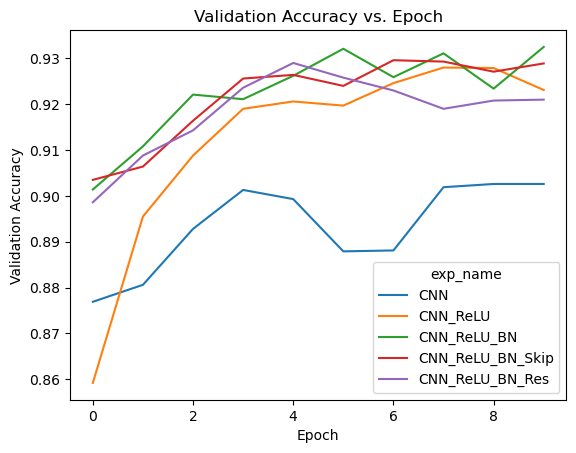

In [ ]:
# CNN + BatchNorm + LeakyReLU + Residual

#Whats the width and height of our images?
W, H = 28, 28 #
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images
#Hidden layer size
n = 256
#How many channels are in the input?
C = 1
#how many filters per convolutional layer
n_filters = 32
#How many classes are there?
classes = 10

class ResidualBlockE(nn.Module):
    def __init__(self, channels, kernel_size=3, leak_rate=0.1):
        """
        channels: how many channels are in the input/output to this layer
        kernel_size: how large of a filter should we use
        leak_rate: paramter for the LeakyReLU activation function
        """
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2

        #Define the conv an BN layers we will use in a sub-network, just 2 hidden layers of conv/BN/activation
        self.F = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(leak_rate),
        )

    def forward(self, x):
        return x + self.F(x) #F() has all the work for the long path, we just add it to the input

class ResidualBottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        #how much padding will our convolutional layers need to maintain the input shape
        pad = (kernel_size-1)//2
        #The botteneck should be smaller, so output/4 or input. You could also try changing max to min, its not a major issue.
        bottleneck = max(out_channels//4, in_channels)
        #Define the three sets of BN and convolution layers we need.
        #Notice that for the 1x1 convs we use padding=0, because 1x1 will not change shape!
        self.F = nn.Sequential(
            #Compress down
            nn.BatchNorm2d(in_channels),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(in_channels, bottleneck, 1, padding=0),
            #Normal layer doing a full conv
            nn.BatchNorm2d(bottleneck),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad),
            #Expand back up
            nn.BatchNorm2d(bottleneck),
            nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, out_channels, 1, padding=0)
        )

        #By default, our shortcut will be the identiy function - which simply returns the input as the output
        self.shortcut = nn.Identity()
        #If we need to change the shape, then lets turn the shortcut into a small layer with 1x1 conv and BM
        if in_channels != out_channels:
            self.shortcut =  nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, padding=0),
                    nn.BatchNorm2d(out_channels)
                )

    def forward(self, x):
        # shortcut(x) plays the role of "x", do as little work as possible to keep the tensor shapes the same.
        return self.shortcut(x) + self.F(x)

leak_rate = 0.1

cnn_res_model = nn.Sequential(
    ResidualBottleNeck(C, n_filters), #BottleNeck to start because we need more channels. Its also common to start with just one normal hidden layer before starting residual blocks.
    nn.LeakyReLU(leak_rate), #We are inserting a activation after each residual. This is optional.
    ResidualBlockE(n_filters),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
    ResidualBottleNeck(n_filters, 2*n_filters),
    nn.LeakyReLU(leak_rate),
    ResidualBlockE(2*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)),
    ResidualBottleNeck(2*n_filters, 4*n_filters),
    nn.LeakyReLU(leak_rate),
    ResidualBlockE(4*n_filters),
    nn.LeakyReLU(leak_rate),
    nn.Flatten(),
    nn.Linear(D*n_filters//4, classes),
)


summary_str = summary(cnn_res_model, input_size = (600,1,28,28), depth=4, col_names = ["input_size","output_size","num_params"])
print(summary_str)

exper_name = "CNN_ReLU_BN_Res"
root_save_dir = './FashionMNIST'
light_model = MNISTLightningModel(cnn_res_model, num_classes = 10)

df14 = run_experiment(light_model, root_save_dir, exper_name, max_epochs=10, verbose = 1)
plot_valid_acc( pd.concat([df10, df11, df12, df13, df14]) )